In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import google.generativeai as genai
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
import torch
import pandas as pd
from tqdm import tqdm

In [3]:
X_train = pd.read_csv("/content/drive/MyDrive/Müş/Proje4/deneme_data/X_train2.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Müş/Proje4/deneme_data/X_test2.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Müş/Proje4/deneme_data/y_train2.csv")
y_test = pd.read_csv("/content/drive/MyDrive/Müş/Proje4/deneme_data/y_test2.csv")

In [10]:
X_train

,original
0,nice place stay good hotel subway station walk...
1,"great 3 star location unbeatable, corporate ho..."
2,"copley house not good experience, avoid place ..."
3,"best, love hotel, stayed trips amsterdam, not ..."
4,"bad bad bad hotel verry bad pls not stay, clos..."
...,...
95,"basic ok, great location stag weekend 8 lads r..."
96,stay taxi driver laughed said novotel century ...
97,"walls hear people door stayed 4 nights paid 1,..."
98,comfortable place good location hotel comforta...


In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [11]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
from tqdm import tqdm

# Model ve tokenizer'ı yükleme
model_name = "eugenesiow/bart-paraphrase"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Paraphrasing fonksiyonu
def paraphrase_text(text, max_length=100):
    prompt = f"Rewrite the following differently: {text}"  # Prompt ekleyerek daha iyi sonuç alınabilir.

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)

    outputs = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        num_return_sequences=4,  # Çeşitli paraphrasing seçenekleri almak için
        do_sample=True,  # Sampling aktif edildi
        temperature=1.8,  # Çıktılarda çeşitlilik için sıcaklık artırıldı
        top_k=50,
        top_p=0.9,
        repetition_penalty=2.0,
        num_beams=5  # Beam search ile çeşitliliği artır
    )

    return [tokenizer.decode(output, skip_special_tokens=True).strip() for output in outputs]

# X_train DataFrame üzerinde paraphrasing uygulama
def generate_paraphrased_dataframe(X_train):
    if 'original' not in X_train.columns:
        raise KeyError(f"Sütun adı 'original' bulunamadı. Mevcut sütunlar: {X_train.columns}")

    data = []

    for index, row in tqdm(X_train.iterrows(), total=X_train.shape[0], desc="Generating paraphrases"):
        original_text = row['original']  # 'Text' sütunundan veri al
        paraphrased_texts = paraphrase_text(original_text)
        row_data = [original_text] + paraphrased_texts  # Orijinal + 4 paraphrased versiyon
        data.append(row_data)

    df_paraphrased = pd.DataFrame(data, columns=['original', 'augmented_1', 'augmented_2', 'augmented_3', 'augmented_4'])
    return df_paraphrased

# Paraphrase edilmiş veriyi DataFrame'e dönüştür
df_paraphrased = generate_paraphrased_dataframe(X_train)

Generating paraphrases: 100%|██████████| 100/100 [20:28<00:00, 12.29s/it]


In [13]:
df_paraphrased.to_csv("/content/drive/MyDrive/Müş/Proje4/deneme_data/bart_deneme.csv", index=False)

In [15]:
df_augmented = df_paraphrased.copy()

In [16]:
df_2x = pd.concat([df_augmented[['original']], df_augmented[['augmented_1']].rename(columns={"augmented_1": "original"})], ignore_index=True)
y_expanded = pd.concat([y_train, y_train], ignore_index=True)
# Yeni sütunu df_2x'e ekleyelim
df_2x["y"] = y_expanded.values
df_2x

,original,y
0,nice place stay good hotel subway station walk...,3
1,"great 3 star location unbeatable, corporate ho...",2
2,"copley house not good experience, avoid place ...",0
3,"best, love hotel, stayed trips amsterdam, not ...",4
4,"bad bad bad hotel verry bad pls not stay, clos...",1
...,...,...
195,"Rewrite the following differently: basic ok, g...",2
196,Rewrite the following differently: stay taxi d...,1
197,Rewrite the following differently: walls hear ...,1
198,Rewrite the following differently: comfortable...,2


In [17]:
df_3x = pd.concat([
    df_augmented[['original']],
    df_augmented[['augmented_1']].rename(columns={"augmented_1": "original"}),
    df_augmented[['augmented_2']].rename(columns={"augmented_2": "original"})
], ignore_index=True)

# y_train etiketlerini tekrarlayarak ekle
y_expanded = pd.concat([y_train, y_train, y_train], ignore_index=True)
df_3x["y"] = y_expanded.values
df_3x

,original,y
0,nice place stay good hotel subway station walk...,3
1,"great 3 star location unbeatable, corporate ho...",2
2,"copley house not good experience, avoid place ...",0
3,"best, love hotel, stayed trips amsterdam, not ...",4
4,"bad bad bad hotel verry bad pls not stay, clos...",1
...,...,...
295,"Rewrite the following differently: basic ok, g...",2
296,Rewrite the following differently: stay taxi d...,1
297,Rewrite the following differently: walls hear ...,1
298,Rewrite the following differently: comfortable...,2


In [18]:
df_5x = pd.concat([
    df_augmented[['original']],
    df_augmented[['augmented_1']].rename(columns={"augmented_1": "original"}),
    df_augmented[['augmented_2']].rename(columns={"augmented_2": "original"}),
    df_augmented[['augmented_3']].rename(columns={"augmented_3": "original"}),
    df_augmented[['augmented_4']].rename(columns={"augmented_4": "original"})
], ignore_index=True)

# y_train değerlerini 5 kez tekrar ederek ekle
y_expanded = pd.concat([y_train] * 5, ignore_index=True)

# Yeni y sütununu ekle
df_5x["y"] = y_expanded.values
df_5x

,original,y
0,nice place stay good hotel subway station walk...,3
1,"great 3 star location unbeatable, corporate ho...",2
2,"copley house not good experience, avoid place ...",0
3,"best, love hotel, stayed trips amsterdam, not ...",4
4,"bad bad bad hotel verry bad pls not stay, clos...",1
...,...,...
495,"Rewrite the following differently: basic ok, g...",2
496,Rewrite the following differently: stay taxi d...,1
497,Rewrite the following differently: walls hear ...,1
498,Rewrite the following differently: comfortable...,2


In [19]:
y_2x_train=df_2x["y"]
y_3x_train=df_3x["y"]
y_5x_train=df_5x["y"]

In [22]:
X_train

,original
0,nice place stay good hotel subway station walk...
1,"great 3 star location unbeatable, corporate ho..."
2,"copley house not good experience, avoid place ..."
3,"best, love hotel, stayed trips amsterdam, not ..."
4,"bad bad bad hotel verry bad pls not stay, clos..."
...,...
95,"basic ok, great location stag weekend 8 lads r..."
96,stay taxi driver laughed said novotel century ...
97,"walls hear people door stayed 4 nights paid 1,..."
98,comfortable place good location hotel comforta...


In [24]:
X_test_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(X_test["Review"].tolist(),batch_size=32,show_progress_bar=True)
X_original_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(X_train["original"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
X_2x_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(df_2x["original"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [26]:
X_3x_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(df_3x["original"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
X_5x_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(df_5x["original"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

## model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 0.56
Test F1 Score: 0.57


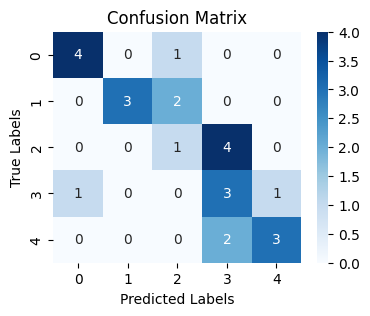

In [29]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', C=1.0, probability=True)
svm_model.fit(X_original_train_embeddings, y_train)

y_pred = svm_model.predict(X_test_embeddings)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test F1 Score: {f1:.2f}")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Test Accuracy: 0.56
Test F1 Score: 0.57


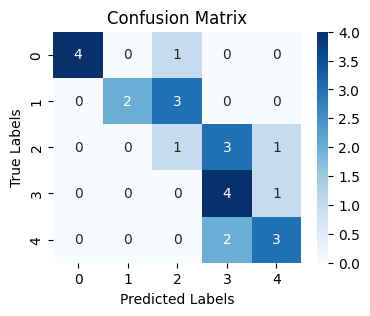

In [30]:

svm_model = SVC(kernel='linear', C=1.0, probability=True)
svm_model.fit(X_2x_train_embeddings, y_2x_train)

y_pred = svm_model.predict(X_test_embeddings)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test F1 Score: {f1:.2f}")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Test Accuracy: 0.56
Test F1 Score: 0.54


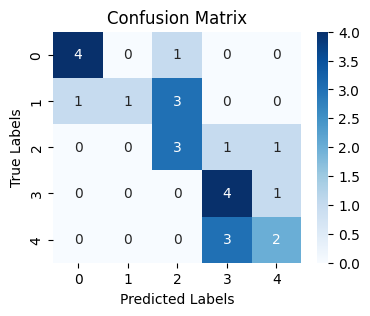

In [31]:

svm_model = SVC(kernel='linear', C=1.0, probability=True)
svm_model.fit(X_3x_train_embeddings, y_3x_train)

y_pred = svm_model.predict(X_test_embeddings)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test F1 Score: {f1:.2f}")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Test Accuracy: 0.60
Test F1 Score: 0.57


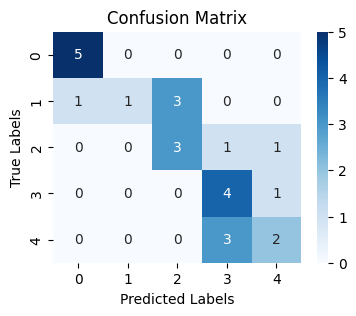

In [32]:

svm_model = SVC(kernel='linear', C=1.0, probability=True)
svm_model.fit(X_5x_train_embeddings, y_5x_train)

y_pred = svm_model.predict(X_test_embeddings)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test F1 Score: {f1:.2f}")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [34]:
X_test

,Review
0,"worst, worst hotel experiences life, moment wi..."
1,"avoid, avoid hotel, rooms small noisy limited ..."
2,"stay away briefly hotel big prolem manager, re..."
3,poor customer service poor customer service no...
4,unfair loss credit card holiday not card used ...
5,ok hotel watch price breakfast 6 ahead nothing...
6,corporate feel no character plan visting bosto...
7,booked hotel rydges web site billy elliot capi...
8,"n't hotels website pictures, hello dissapointe..."
9,disappointing needed transportation hotel ball...


In [35]:
device = 0 if torch.cuda.is_available() else -1
generator = pipeline("text2text-generation", model="eugenesiow/bart-paraphrase", device=device)

# Her test metni için prompt oluştur ve BART modelini uygula
prompts = [f"Paraphrase: {text}" for text in X_test["Review"]]

# Modelden paraphrase'ler al
results = generator(
    prompts,
    max_length=120,
    num_return_sequences=4,
    do_sample=True,
    top_k=100,
    top_p=0.95,
    temperature=1.0,
    repetition_penalty=1.3,
    early_stopping=True
)

# Üretilen metinleri düzenleme
augmented_sentences = []
for result_list in results:
    generated_texts = [item['generated_text'] for item in result_list]
    augmented_sentences.append(generated_texts)

Device set to use cpu


In [37]:
# --- Test verisini 3x ve 5x artırılmış halde oluştur ---
X_test_3x = []
X_test_5x = []

for i in range(len(X_test["Review"])):
    X_test_3x.append(X_test["Review"].iloc[i])
    X_test_5x.append(X_test["Review"].iloc[i])

    # İlk 2 artırılmış metin 3x veri setine ekleniyor
    X_test_3x.extend(augmented_sentences[i][:2])

    # Tüm 4 artırılmış metin 5x veri setine ekleniyor
    X_test_5x.extend(augmented_sentences[i])

In [38]:
X_test_3x_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(X_test_3x, batch_size=32, show_progress_bar=True)
X_test_5x_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(X_test_5x, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [41]:
# --- Model Tahminleri ---
svm_model = SVC(kernel='linear', C=1.0, probability=True)
svm_model.fit(X_original_train_embeddings, y_train)
original_predictions = svm_model.predict(X_test_embeddings)
predictions_3x = svm_model.predict(X_test_3x_embeddings)
predictions_5x = svm_model.predict(X_test_5x_embeddings)

# --- Karar Birleştirme Fonksiyonu ---
from scipy.stats import mode
def majority_voting(original_pred, augmented_preds):
    all_preds = augmented_preds + [original_pred]
    final_decision = mode(all_preds, keepdims=True).mode[0]
    return final_decision

# --- Nihai Kararların Belirlenmesi ---
final_predictions_3x = []
final_predictions_5x = []

for i in range(len(original_predictions)):
    combined_preds_3x = [
        original_predictions[i],   # Orijinal tahmin
        predictions_3x[i * 3],     # 1. artırılmış tahmin
        predictions_3x[i * 3 + 1]  # 2. artırılmış tahmin
    ]
    final_decision_3x = mode(combined_preds_3x, keepdims=True).mode[0]
    final_predictions_3x.append(final_decision_3x)

for i in range(len(original_predictions)):
    combined_preds_5x = [
        original_predictions[i],   # Orijinal tahmin
        predictions_5x[i * 5],     # 1. artırılmış tahmin
        predictions_5x[i * 5 + 1], # 2. artırılmış tahmin
        predictions_5x[i * 5 + 2], # 3. artırılmış tahmin
        predictions_5x[i * 5 + 3]  # 4. artırılmış tahmin
    ]
    final_decision_5x = mode(combined_preds_5x, keepdims=True).mode[0]
    final_predictions_5x.append(final_decision_5x)

# Sonuçları ekrana yazdır
print("Original Test Accuracy:", accuracy_score(y_test, original_predictions))
print("3x Augmented Test Accuracy:", accuracy_score(y_test, final_predictions_3x))
print("5x Augmented Test Accuracy:", accuracy_score(y_test, final_predictions_5x))

Original Test Accuracy: 0.56
3x Augmented Test Accuracy: 0.56
5x Augmented Test Accuracy: 0.64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
